To run, make sure you have the following folder layout:

- Main folder/
    - kaggle.ipynb
    - data/
        - test_images/
            - (all testing images)
        - train_images/
            - (all training images)
        - test.csv
        - train.csv
    - checkpoints/
        - (this is where checkpoints will be saved to)

Path constants can be changed below if you prefer a different layout

In [1]:
# Import libraries
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
import torchvision.models as models
from torcheval.metrics.functional import r2_score

import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset, DataLoader

In [2]:
# Parameters
BATCH_SIZE = 64
EPOCH_COUNT = 8

# Use graphics card if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda


In [3]:
# Define paths
DATA_PATH = 'data/'
TRAIN_IMAGES_PATH = DATA_PATH + 'train_images/'
TEST_IMAGES_PATH = DATA_PATH + 'test_images/'
TRAIN_ANCILLARY_PATH = DATA_PATH + 'train.csv'
TEST_ANCILLARY_PATH = DATA_PATH + 'test.csv'

SAVE_MODEL = True
LOAD_MODEL = False
CHECKPOINT_PATH = 'checkpoints/'
OUTPUT_PATH = 'submission.csv'

### Model using pretrained EfficientNet from torchvision

In [4]:
class Model(nn.Module):
    def __init__(self, ancillary_tensor_size):
        super().__init__()

        # Remove final classifier layer from pretrained model
        self.efficientnet = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        self.efficientnet.classifier = nn.Sequential()

        # Add our own final classifier layer for classification
        self.dropout = nn.Dropout(p=0.4, inplace=False)
        self.fc = nn.Linear(1280 + ancillary_tensor_size, 1280 + ancillary_tensor_size)
        self.batchnorm = nn.BatchNorm1d(1280 + ancillary_tensor_size)
        self.relu = nn.ReLU()
        #Dropout2
        self.classifier = nn.Linear(1280 + ancillary_tensor_size, 6)


    def forward(self, image_tensor, ancillary_tensor):
        # Pass through the entire pretrained model with the image tensor with a final linear layer
        x = self.efficientnet(image_tensor)
        
        # Concatenate result with ancillary data
        x = torch.cat((x, ancillary_tensor), dim=1)

        # Run our classifier
        x = self.dropout(x)

        x = self.fc(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.classifier(x)
        
        return x
  
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

### Load data

In [5]:
# Binary tree implementation
class Node():
    def __init__(self, key, value):
        self.key = key
        self.value = value
        
        self.left = None
        self.right = None

    def insert(self, node):
        # Check for duplicate key
        if self.key == node.key: return False
        # Insert to left
        elif node.key < self.key:
            if self.left:
                return self.left.insert(node)
            else:
                self.left = node
                return True
        # Insert to right
        elif node.key > self.key:
            if self.right:
                return self.right.insert(node)
            else:
                self.right = node
                return True
            

    def delete(self, key):
        # Search to the left
        if key < self.key and self.left is not None:
            self.left = self.left.delete(key)
        # Search to the right
        elif key > self.key and self.right is not None:
            self.right = self.right.delete(key)
        # Key matches current node
        elif key == self.key:
            # 0 or 1 children
            if self.left is None: return self.right
            elif self.right is None: return self.left
            
            # 2 children
            # Find successor
            successor = self.right
            while successor is not None and successor.left is not None:
                successor = successor.left
            
            self.key = successor.key
            self.right = self.right.delete(successor.key)

        return self
        

    def search(self, key):
        # Found
        if self.key == key: return self

        # Search to the left
        if key < self.key and self.left is not None:
            return self.left.search(key)
        # Search to the right
        elif key > self.key and self.right is not None:
            return self.right.search(key)
        
        # Not found
        return None

    def print_key(self, level=0):
        result = '\t' * level + f'{self.key}' + '\n'

        if self.left is not None: result += self.left.print_key(level + 1)
        if self.right is not None: result += self.right.print_key(level + 1)

        return result


def create_tree(np_matrix):
    root = Node(np_matrix[0][0], np_matrix[0][1 : ])

    for i in range(1, np_matrix.shape[0]):
        node = Node(np_matrix[i][0], np_matrix[i][1 : ])
        root.insert(node)

    return root

In [6]:
# Dataset class to hold images and ancillary information
class PlantDataset(Dataset):
    def __init__(self, images_path, ancillary_path, label_count=6):
        image_ids = [os.path.splitext(file)[0] for file in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, file))]
        
        # Create binary search tree for ancillary data
        ancillary_np = pd.read_csv(ancillary_path).to_numpy(dtype=np.float32)
        self.ancillary_tree = create_tree(ancillary_np)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(0.5))
        ])

        # Augment dataset so that we don't have to do it later
        self.augmented_data = []
        for image_id in tqdm(image_ids):

            # Store image path
            image_path = os.path.join(images_path, image_id + '.jpeg')

            # Find the corresponding set of ancillary data
            data = self.ancillary_tree.search(np.float32(image_id)).value
            if data is not None:
                if (label_count == 0):
                    labels = []
                    ancillary_tensor = torch.tensor(data, dtype=torch.float32)
                else:
                    labels = data[-label_count : ]
                    ancillary_tensor = torch.tensor(data[ : -label_count], dtype=torch.float32)
            else:
                labels = None
                ancillary_tensor = None
                print(f'No ancillary data found for image {image_id}')

            # Normalize ancillary tensor
            ancillary_tensor = (ancillary_tensor - ancillary_tensor.mean()) / ancillary_tensor.max()
                    
            # Data found, add into list
            self.augmented_data.append((image_id, image_path, labels, ancillary_tensor))
            
        if not label_count == 0:
            # Calculate mean and standard deviation of labels
            labels = [data[2] for data in self.augmented_data]
            means = np.mean(labels, axis=0)
            standard_deviations = np.std(labels, axis=0)

            # Remove outliers from augmented dataset
            original_size = len(self.augmented_data)
            self.augmented_data = [data for data in self.augmented_data if all(abs((data[2] - means) / standard_deviations) < 3)]
            print(f'Removed {original_size - len(self.augmented_data)} items')


    def __len__(self):
        return len(self.augmented_data)


    def __getitem__(self, idx):
        image_id, image_path, labels, ancillary_tensor = self.augmented_data[idx]

        # Open and transform image
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        return image_id, image_tensor, labels, ancillary_tensor

In [7]:
# Load datasets
full_train_dataset = PlantDataset(TRAIN_IMAGES_PATH, TRAIN_ANCILLARY_PATH, label_count=6)
test_dataset = PlantDataset(TEST_IMAGES_PATH, TEST_ANCILLARY_PATH, label_count=0)

# Split training dataset to create validation dataset
indices = list(range(len(full_train_dataset)))
split = int(0.9 * len(full_train_dataset))
total = int(1 * len(full_train_dataset))

train_dataset = Subset(full_train_dataset, indices[ : split])
val_dataset = Subset(full_train_dataset, indices[split : total])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 43363/43363 [00:01<00:00, 24103.96it/s]


Removed 3152 items


100%|██████████| 6391/6391 [00:00<00:00, 28030.65it/s]


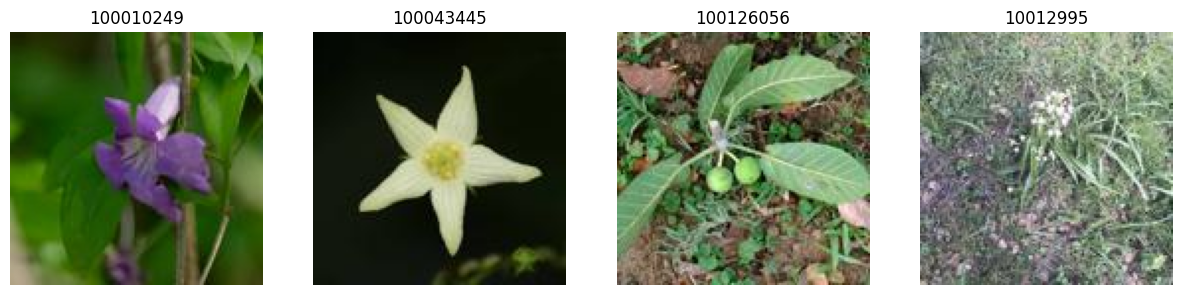

In [8]:
# Visualization
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_id, image, labels, ancillary_data = train_dataset[i]

    # Convert the image from tensor to numpy array
    image = image.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC format

    # Convert from [-1, 1] to [0, 255]
    image = ((image + 1) * 255 / 2).astype(np.uint8)

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"{image_id}")

plt.show()

### Training

In [9]:
# Initialize model
model = Model(ancillary_tensor_size=163).to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99))
L1_LAMBDA = 0.01 # For L1 regularization implemented in the training loop

# Initialize learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

epoch = 1
train_total_losses = []
train_total_scores = []
val_total_losses = []
val_total_scores = []

In [10]:
if LOAD_MODEL:
    # Load model
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_total_losses = checkpoint['train_total_losses']
    train_total_scores = checkpoint['train_total_scores']
    val_total_losses = checkpoint['train_total_losses']
    val_total_scores = checkpoint['train_total_scores']

In [11]:
# Loop through all epochs
while epoch <= EPOCH_COUNT:
    print(f"Epoch [{epoch}/{EPOCH_COUNT}]")

    # Training ==================================================
    model.train()

    train_total_loss = 0
    train_total_score = 0
    train_score_count = 0

    # Loop through all batches
    for image_id, image_tensor, labels, ancillary_tensor in tqdm(train_dataloader):
        image_tensor, ancillary_tensor, labels = image_tensor.to(device), ancillary_tensor.to(device), labels.to(device)

        # Train model
        optimizer.zero_grad()
        predictions = model(image_tensor, ancillary_tensor)

        # Calculate loss
        mse_loss = nn.functional.mse_loss(predictions, labels)

        # Add L1 regularization
        l1_norm = sum(param.abs().sum() for param in model.parameters())
        l1_loss = L1_LAMBDA * l1_norm
        
        loss = mse_loss + l1_loss

        loss.backward()
        optimizer.step()

        # Add to loss
        train_total_loss += loss * BATCH_SIZE

        # Calculate score
        for prediction, label in zip(predictions, labels):
            score = r2_score(prediction, label)
            train_total_score += score
            train_score_count += 1

    train_total_losses.append((train_total_loss / len(train_dataloader)).cpu())
    train_total_scores.append((train_total_score / train_score_count).cpu())

    # Validation ==================================================
    model.eval()

    val_total_loss = 0
    val_total_score = 0
    val_score_count = 0

    # Loop through all batches
    for image_id, image_tensor, labels, ancillary_tensor in tqdm(val_dataloader):
        image_tensor, ancillary_tensor, labels = image_tensor.to(device), ancillary_tensor.to(device), labels.to(device)

        # Get prediction
        with torch.no_grad():
            predictions = model(image_tensor, ancillary_tensor)
        
        # Calculate loss
        mse_loss = nn.functional.mse_loss(predictions, labels)

        # Add L1 regularization
        l1_norm = sum(param.abs().sum() for param in model.parameters())
        l1_loss = L1_LAMBDA * l1_norm
            
        loss = mse_loss + l1_loss

        # Add to loss
        val_total_loss += loss * BATCH_SIZE

        # Calculate score
        for prediction, label in zip(predictions, labels):
            score = r2_score(prediction, label)
            val_total_score += score
            val_score_count += 1

    val_total_losses.append((val_total_loss / len(val_dataloader)).cpu())
    val_total_scores.append((val_total_score / val_score_count).cpu())
    
    print(f'Epoch train loss: {train_total_loss / len(train_dataloader)} \
        Epoch train score: {train_total_score / train_score_count}')
    print(f'Epoch val loss: {val_total_loss / len(val_dataloader)} \
        Epoch val score: {val_total_score / val_score_count}')
        
    # Update learning rate scheduler
    prev_lr = scheduler.get_last_lr()
    scheduler.step(val_total_loss)
    if scheduler.get_last_lr() != prev_lr:
        print('-- Learning rate reduced')
    
    if SAVE_MODEL:
        # Save model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_total_losses': train_total_losses,
            'train_total_scores': train_total_scores,
            'val_total_losses': val_total_losses,
            'val_total_scores': val_total_scores
        }, CHECKPOINT_PATH + f'checkpoint_{epoch}.pth.tar')
    
    epoch += 1

Epoch [1/8]


100%|██████████| 63/63 [00:18<00:00,  3.33it/s]


Epoch train loss: 1458079531008.0         Epoch train score: -0.053990624845027924
Epoch val loss: 1027226271744.0         Epoch val score: 0.2589826285839081
Epoch [2/8]


100%|██████████| 63/63 [00:06<00:00, 10.47it/s]


Epoch train loss: 584714289152.0         Epoch train score: 0.5771915316581726
Epoch val loss: 173490094080.0         Epoch val score: 0.8748919367790222
Epoch [3/8]


100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Epoch train loss: 42873745408.0         Epoch train score: 0.9690507054328918
Epoch val loss: 257106800.0         Epoch val score: 0.9998358488082886
Epoch [4/8]


100%|██████████| 63/63 [00:06<00:00,  9.91it/s]


Epoch train loss: 2127473408.0         Epoch train score: 0.9985566139221191
Epoch val loss: 143281216.0         Epoch val score: 0.9999082684516907
Epoch [5/8]


100%|██████████| 63/63 [00:06<00:00, 10.07it/s]


Epoch train loss: 1875854592.0         Epoch train score: 0.9987433552742004
Epoch val loss: 177315312.0         Epoch val score: 0.9998891353607178
Epoch [6/8]


100%|██████████| 63/63 [00:07<00:00,  8.88it/s]


Epoch train loss: 1542039808.0         Epoch train score: 0.9989885091781616
Epoch val loss: 1437501440.0         Epoch val score: 0.9989724159240723
Epoch [7/8]


100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Epoch train loss: 1284601984.0         Epoch train score: 0.9991787075996399
Epoch val loss: 39016275968.0         Epoch val score: 0.9716983437538147
Epoch [8/8]


100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


Epoch train loss: 1216200832.0         Epoch train score: 0.9992296695709229
Epoch val loss: 1317718400.0         Epoch val score: 0.9990718960762024
-- Learning rate reduced


In [12]:
if SAVE_MODEL:
    # Save model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_total_losses': train_total_losses,
        'train_total_scores': train_total_scores,
        'val_total_losses': val_total_losses,
        'val_total_scores': val_total_scores,
        }, CHECKPOINT_PATH + 'checkpoint_final.pth.tar')

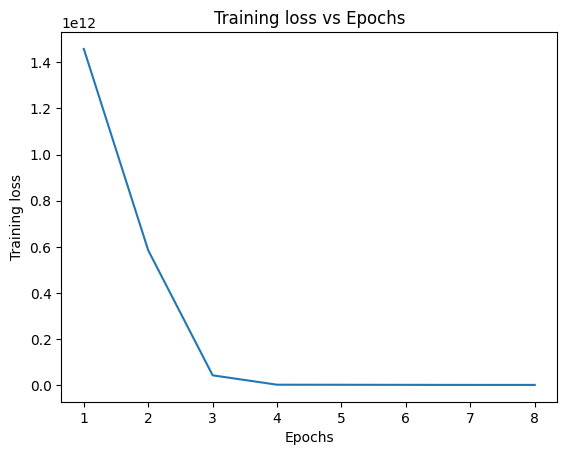

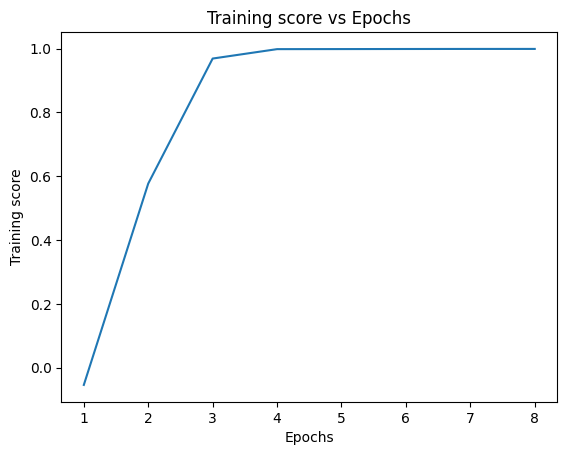

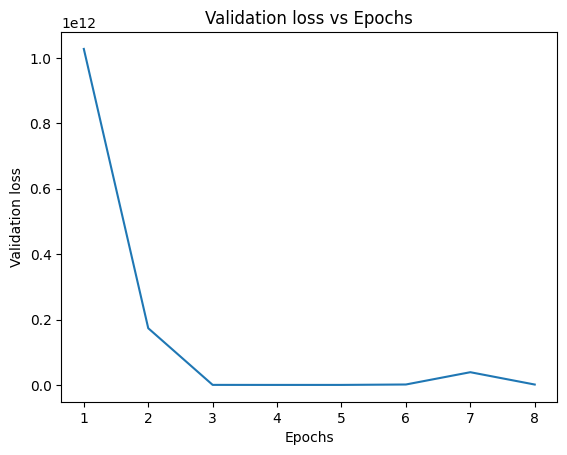

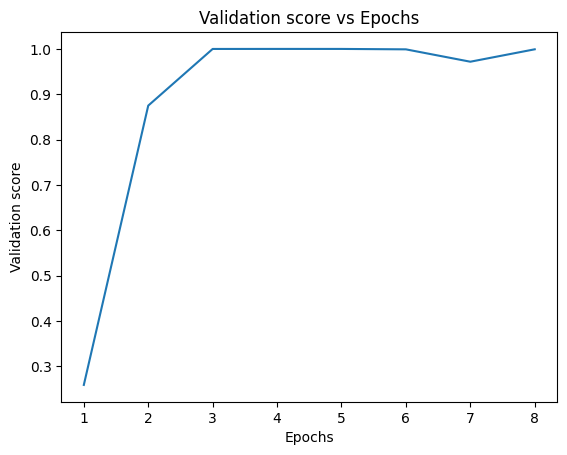

In [13]:
# Plot results
x_points = range(1, EPOCH_COUNT + 1)

# Convert tensors to regular floats
train_losses_points = [loss.item() for loss in train_total_losses]
train_scores_points = [score.item() for score in train_total_scores]
val_losses_points = [loss.item() for loss in val_total_losses]
val_scores_points = [score.item() for score in val_total_scores]

plt.plot(x_points, train_losses_points)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.title("Training loss vs Epochs")
plt.show()

plt.plot(x_points, train_scores_points)
plt.xlabel("Epochs")
plt.ylabel("Training score")
plt.title("Training score vs Epochs")
plt.show()

plt.plot(x_points, val_losses_points)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss vs Epochs")
plt.show()

plt.plot(x_points, val_scores_points)
plt.xlabel("Epochs")
plt.ylabel("Validation score")
plt.title("Validation score vs Epochs")
plt.show()

### Testing

In [15]:
model.eval()

eval_total_loss = 0
eval_total_score = 0
score_count = 0

# Generate predictions
test_image_ids = []
test_predictions = []
for image_id, image_tensor, labels, ancillary_tensor in tqdm(test_dataloader):
    image_tensor, ancillary_tensor = image_tensor.to(device), ancillary_tensor.to(device)

    with torch.no_grad():
        predictions = model(image_tensor, ancillary_tensor)

    test_image_ids.append(image_id[0])
    test_predictions.append(predictions[0].cpu().numpy())


100%|██████████| 6391/6391 [02:21<00:00, 45.16it/s]


In [16]:
# Convert image ids and predictions to pandas dataframe
output_np = [np.concatenate(([a], b)) for a, b in zip(test_image_ids, test_predictions)]
output_df = pd.DataFrame(output_np)
column_names = ['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
output_df.columns = column_names

In [17]:
# Save predictions to output file
output_df.to_csv(OUTPUT_PATH, index=False, header=True)